# Online Payment Fraud Detection Machine Learning Model

- Dataset fetch from Kaggle [Download Link](https://www.kaggle.com/ealaxi/paysim1/download)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from category_encoders import WOEEncoder

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
sns.set_style('whitegrid') # sets the visual style of Seaborn plots to 'whitegrid', which displays a white background with grid lines.
sns.set_palette('pastel')  # sets the color palette to 'pastel', which is one of the predefined color palettes provided by Seaborn. It consists of a set of visually distinct colors suitable for plotting categorical data.

import warnings
# Ignore all warnings
warnings.simplefilter("ignore")

## Reading Dataset

In [2]:
data = pd.read_csv(r'D:/Sastra_MCA/Sem IV/PS_20174392719_1491204439457_log.csv')
print(data.shape)
data.head()

(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Performing EDA on the dataset

In [3]:
# Checking for null values in the dataset.
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [4]:
# Check the whole dataset and well known about type of features and their datatypes.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
# Removing the unnecessary features for model building and training.
data.drop(columns=['nameOrig', 'nameDest'], axis=1, inplace=True)

In [6]:
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [7]:
# Counting the number of discrete vaulues in the feature 'type'.
data.type.value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

### Visualize the dataset

In [8]:
target = 'isFraud'

In [9]:
# Segregate the counting to plot and visualize the methods of transactions.
type = data['type'].value_counts()
transactions = type.index
quantity = type.values
quantity

array([2237500, 2151495, 1399284,  532909,   41432], dtype=int64)

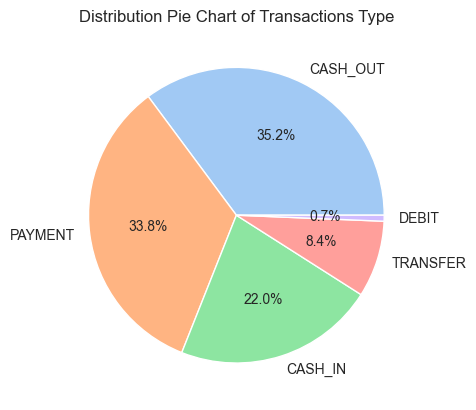

In [10]:
# By plotting the pie chart, visualize the whole dataset.
plt.pie(quantity, labels=transactions, autopct="%1.1f%%")
plt.title('Distribution Pie Chart of Transactions Type')
plt.savefig('static/images/pie_chart.png')
plt.show()

### Converting `type` feature from categorical to numerical feature

In [11]:
data["type"] = data["type"].map({"CASH_OUT": 1, "PAYMENT": 2, "CASH_IN": 3, "TRANSFER": 4, "DEBIT": 5})

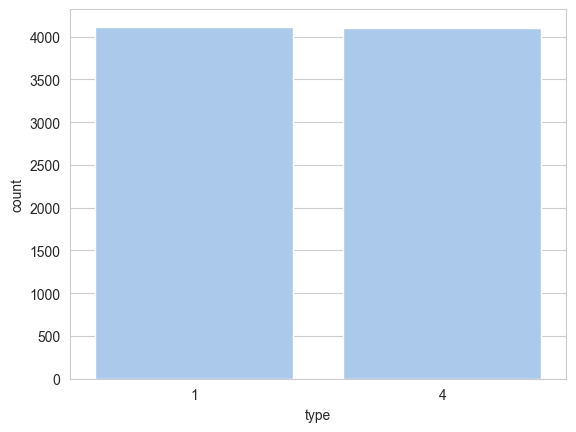

In [12]:
# The types of fraud transactions
sns.countplot(data[data['isFraud']==1], x='type')
plt.show() 

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int64  
 2   amount          float64
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
 7   isFraud         int64  
 8   isFlaggedFraud  int64  
dtypes: float64(5), int64(4)
memory usage: 436.9 MB


### Let's see the correlation of different features with target feature

In [14]:
# Checking for the relation of different features with the target variable.
correlation = data.corr()
correlation[target].sort_values(ascending=False)

isFraud           1.000000
amount            0.076688
isFlaggedFraud    0.044109
step              0.031578
type              0.016171
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64

- Visualize the data graphically

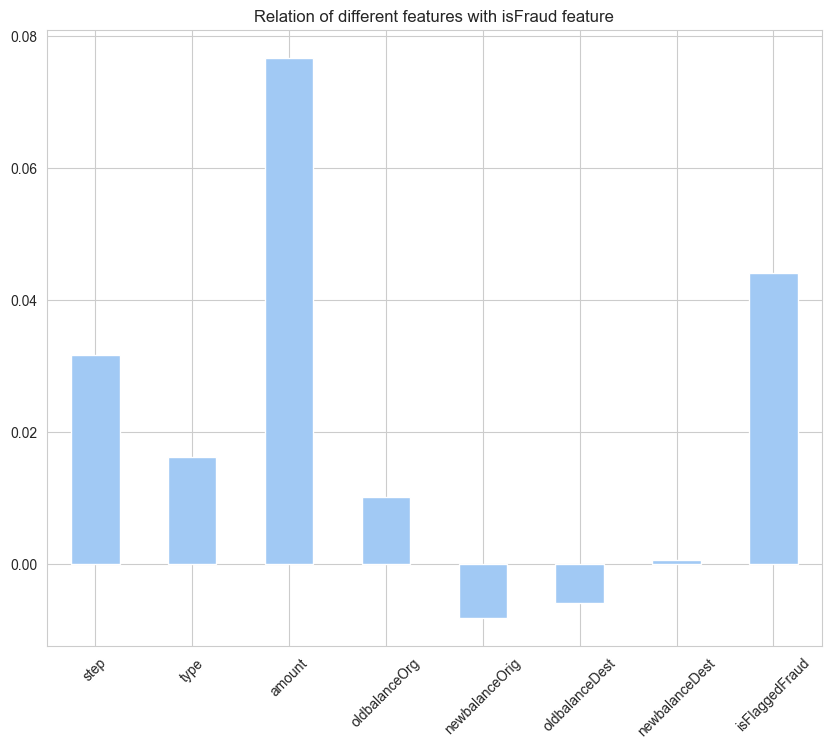

In [15]:
data2 = data.drop(columns=[target], axis=1)
data2.corrwith(data[target]).plot.bar(figsize=(10, 8), title=f'Relation of different features with {target} feature', rot=45, grid=True)
plt.savefig('static/images/target_correlation.png')
plt.show()

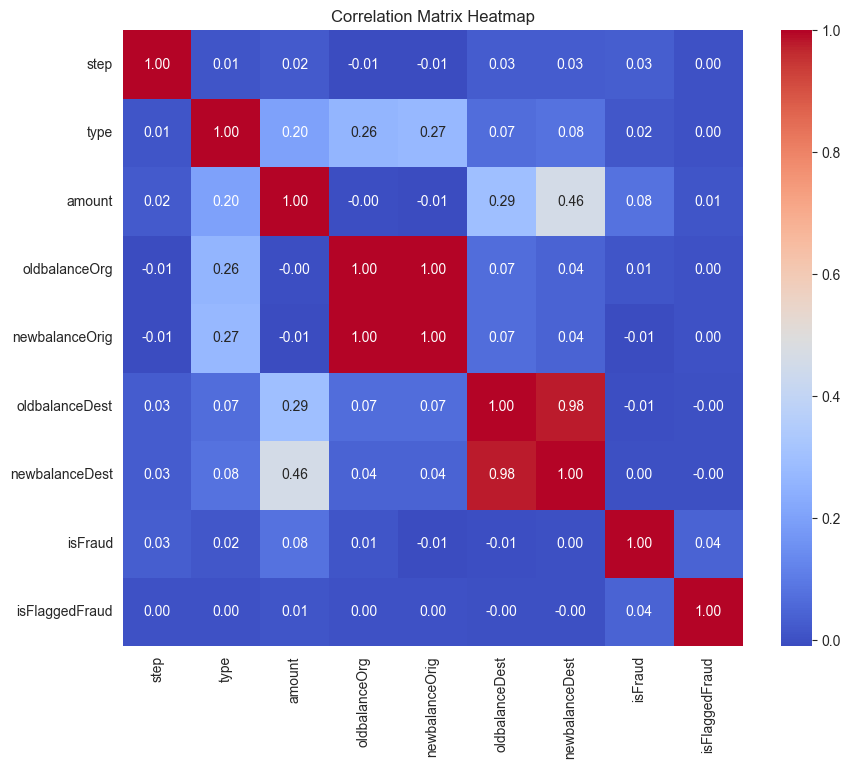

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.savefig('static/images/correlation_heatmap.png')
plt.show()

### Converting target feature into categorical feature

In [17]:
data[target] = data[target].map({0: "No Fraud", 1: "Fraud"})

In [18]:
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,2,9839.64,170136.0,160296.36,0.0,0.0,No Fraud,0
1,1,2,1864.28,21249.0,19384.72,0.0,0.0,No Fraud,0
2,1,4,181.00,181.0,0.00,0.0,0.0,Fraud,0
3,1,1,181.00,181.0,0.00,21182.0,0.0,Fraud,0
4,1,2,11668.14,41554.0,29885.86,0.0,0.0,No Fraud,0


### Visualize the different features correspond to target feature

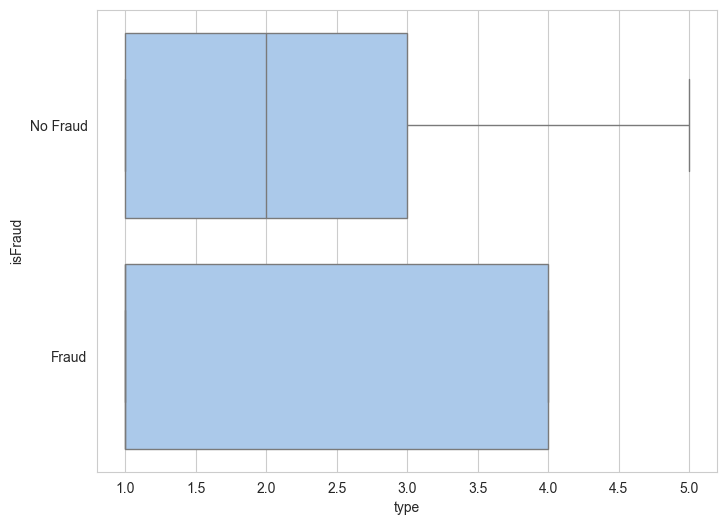

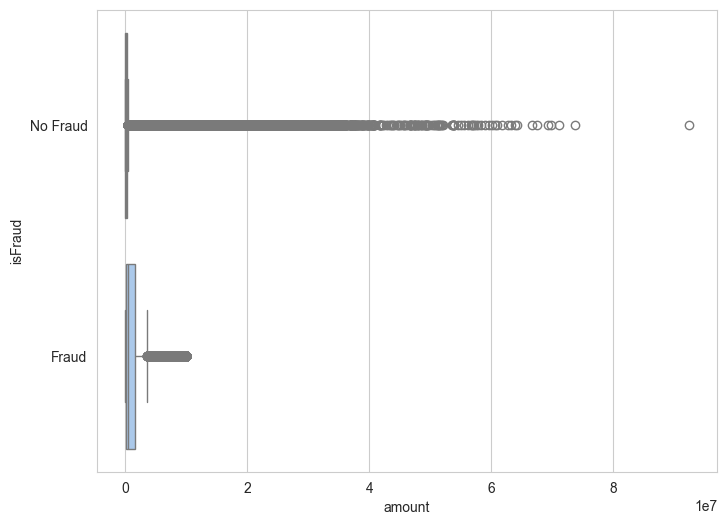

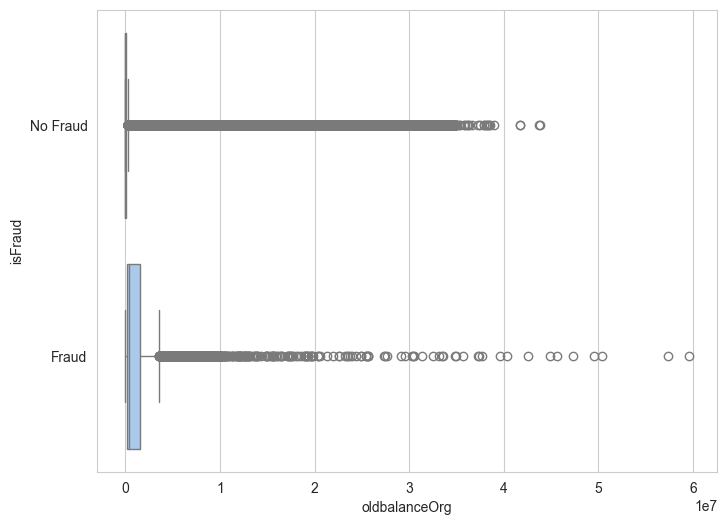

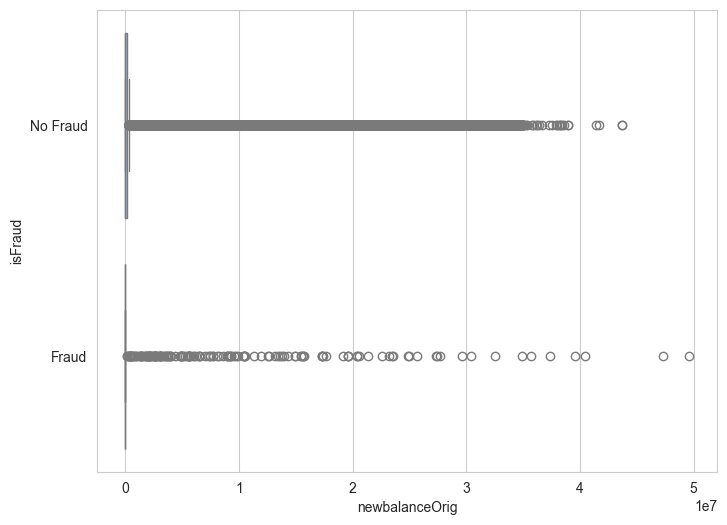

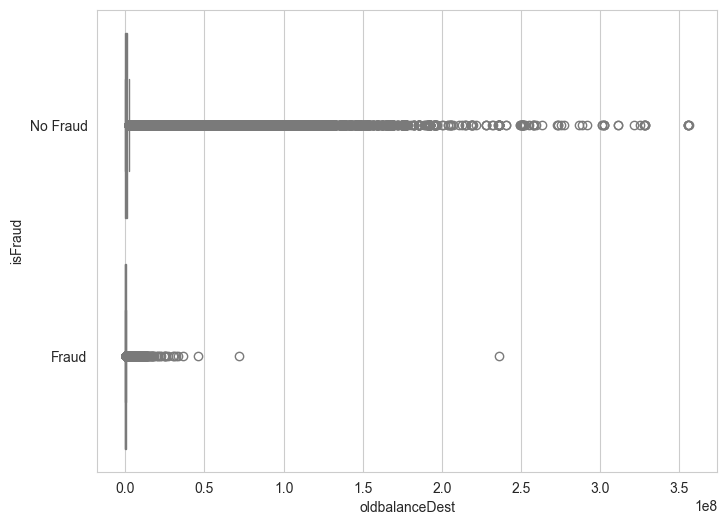

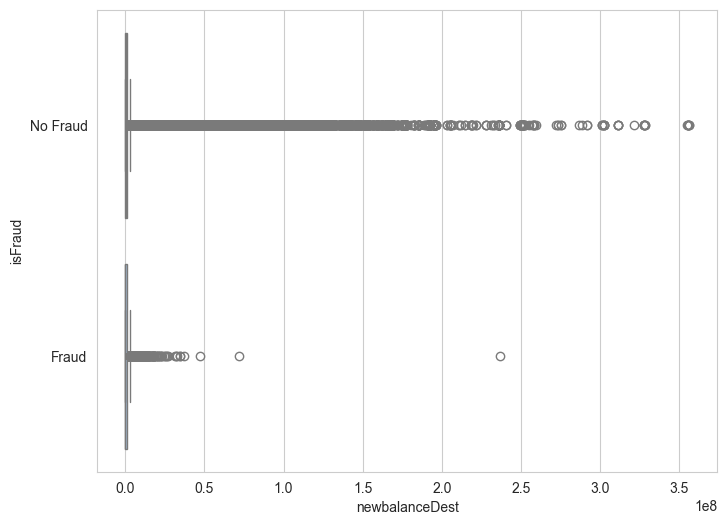

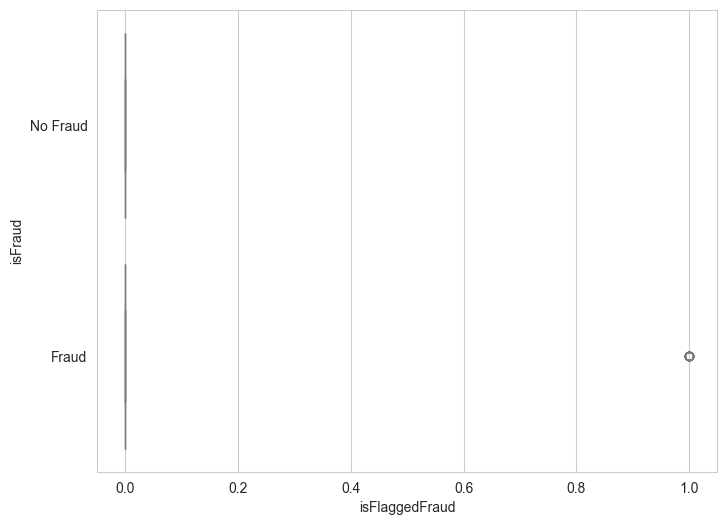

In [19]:
def plot(feature):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=feature, y=target, data=data)
    plt.savefig(f'static/images/{feature}_feature.png')
    plt.show()

features = ['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']
for feature in features:
    plot(feature)

## Start Building the model and train it.

In [20]:
x = np.array(data[["type", "amount", "oldbalanceOrg", "newbalanceOrig"]])
y = np.array(data[[target]])

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

[1] Logistic Regression -> LR

In [22]:
LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)
predict_LR = LR_model.predict(X_test)
print(classification_report(y_test, predict_LR))
LR_accuracy = accuracy_score(predict_LR, y_test)
print('Logistic Regression accuracy is: {:.2f}%'.format(LR_accuracy*100))

              precision    recall  f1-score   support

       Fraud       0.93      0.35      0.51      1620
    No Fraud       1.00      1.00      1.00   1270904

    accuracy                           1.00   1272524
   macro avg       0.96      0.68      0.75   1272524
weighted avg       1.00      1.00      1.00   1272524

Logistic Regression accuracy is: 99.91%


[2] Support Vector Machine Model (SVC)

In [23]:
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
predict = svm_model.predict(X_test)

print(classification_report(y_test, predict))
svm_accuracy = accuracy_score(predict, y_test)
print('SVC model accuracy is: {:.2f}%'.format(svm_accuracy*100))

              precision    recall  f1-score   support

       Fraud       1.00      0.15      0.25      1620
    No Fraud       1.00      1.00      1.00   1270904

    accuracy                           1.00   1272524
   macro avg       1.00      0.57      0.63   1272524
weighted avg       1.00      1.00      1.00   1272524

SVC model accuracy is: 99.89%


[3] GaussianNB

In [24]:
# Create and train the Gaussian Naive Bayes model
NB_model = GaussianNB()
NB_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_naive = NB_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_naive))
GaussianNB_accuracy = accuracy_score(y_pred_naive, y_test)
print('Naive Bayes model accuracy is: {:.2f}%'.format(GaussianNB_accuracy * 100))

              precision    recall  f1-score   support

       Fraud       0.04      0.16      0.07      1620
    No Fraud       1.00      1.00      1.00   1270904

    accuracy                           0.99   1272524
   macro avg       0.52      0.58      0.53   1272524
weighted avg       1.00      0.99      1.00   1272524

Naive Bayes model accuracy is: 99.45%


[4] Decision Tree Model (ID3)

In [25]:
DT = DecisionTreeClassifier(max_depth=(1), random_state=0)
DT.fit(X_train, y_train)
predict_ID3 = DT.predict(X_test)
print(classification_report(y_test, predict_ID3))
ID3_accuracy = accuracy_score(predict_ID3, y_test)
print('ID3 model accuracy is: {:.2f}%'.format(ID3_accuracy*100))

              precision    recall  f1-score   support

       Fraud       0.00      0.00      0.00      1620
    No Fraud       1.00      1.00      1.00   1270904

    accuracy                           1.00   1272524
   macro avg       0.50      0.50      0.50   1272524
weighted avg       1.00      1.00      1.00   1272524

ID3 model accuracy is: 99.87%


[5] RandomForestClassifier

In [26]:
# Initialize and train the Random Forest classifier
RF = RandomForestClassifier(n_estimators=100, random_state=0)
RF.fit(X_train, y_train)

predict_RF = RF.predict(X_test)

# Evaluate the model
print(classification_report(y_test, predict_RF))
RF_accuracy = accuracy_score(predict_RF, y_test)
print('Random Forest model accuracy is: {:.2f}%'.format(RF_accuracy * 100))

              precision    recall  f1-score   support

       Fraud       0.90      0.89      0.90      1620
    No Fraud       1.00      1.00      1.00   1270904

    accuracy                           1.00   1272524
   macro avg       0.95      0.94      0.95   1272524
weighted avg       1.00      1.00      1.00   1272524

Random Forest model accuracy is: 99.97%


[6] XGBClassifier

In [27]:
# Convert y_train and y_test to pandas Series
y_train = pd.Series(y_train.flatten())
y_test = pd.Series(y_test.flatten())

# Map the categorical labels to numerical values
y_train = y_train.map({"No Fraud": 0, "Fraud": 1})
y_test = y_test.map({"No Fraud": 0, "Fraud": 1})

In [28]:
# Initialize and train the XGBoost classifier
XGB = XGBClassifier(random_state=0)
XGB.fit(X_train, y_train)

# Make predictions on the test set
predict_XGB = XGB.predict(X_test)

# Evaluate the model
print(classification_report(y_test, predict_XGB))
XGB_accuracy = accuracy_score(predict_XGB, y_test)
print('XGBoost model accuracy is: {:.2f}%'.format(XGB_accuracy * 100))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.88      0.75      0.81      1620

    accuracy                           1.00   1272524
   macro avg       0.94      0.88      0.91   1272524
weighted avg       1.00      1.00      1.00   1272524

XGBoost model accuracy is: 99.96%


In [29]:
Algorithms = ['XGBClassifier', 'RandomForest', 'ID3', 'Logistic Regression', 'SVC', 'GaussianNB']
accuracy = [XGB_accuracy, RF_accuracy, ID3_accuracy, LR_accuracy, svm_accuracy, GaussianNB_accuracy]

FinalResult=pd.DataFrame({'Algorithm':Algorithms, 'Accuracy':accuracy})

FinalResult

,Algorithm,Accuracy
0,XGBClassifier,0.999555
1,RandomForest,0.999737
2,ID3,0.998727
3,Logistic Regression,0.999138
4,SVC,0.998912
5,GaussianNB,0.994498


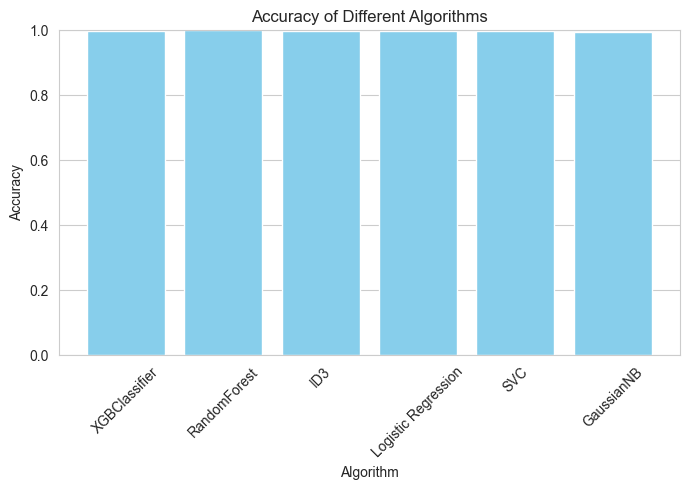

In [30]:
plt.figure(figsize=(7, 5))
plt.bar(FinalResult['Algorithm'], FinalResult['Accuracy'], color='skyblue')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Algorithms')
plt.ylim(0, 1)  # Set the limit of y-axis from 0 to 1 (accuracy ranges from 0 to 1)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(axis='x')  # Add gridlines only along the x-axis
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [31]:
# Let's see the prediction of the model
features = np.array([[4, 9000.60, 9000.60, 0.0]])
print(XGB.predict(features))

[1]


## Converting model into `joblib` extension file to create a website to interact with non-technical user.

In [32]:
import joblib
joblib.dump(RF, 'model.joblib')

['model.joblib']

## Create `requirements.txt` file

In [33]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


## The Model has been fiited using 'RandomForestClassifier' that gave accuracy of 99.97%